# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [56]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from joblib import Parallel, delayed
np.random.seed(2020)
random.seed(2020)

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [34]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

# Cost functions

In this section you should implement two cost functions. Any of these can be used in the model.

## Gini index

In [36]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return 0.0
    p = np.bincount(x) / len(x)
    return 1 - np.sum(p*p)

In [37]:
target = df['target'].values
gini_index(target)

0.4977348372781065

In [38]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    splits_gini = np.sum([gini_index(split)*(len(split)/len(parent_node)) for split in splits])
    return gini_index(parent_node) - splits_gini

In [39]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
gini_gain(target, splits)

-0.0003705758273065962

## Entropy

In [40]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    if len(x) == 0:
        return 0.0
    p = np.clip(np.bincount(x) / len(x), 1e-15, 1.)
    return -np.sum(p * np.log(p))

In [41]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    splits_entropy = np.sum([entropy(split)*(len(split)/len(parent_node)) for split in splits])
    return entropy(parent_node) - splits_entropy

# Split function

Implement split functions

In [42]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

# Decision tree

In [43]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self, criterion=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = criterion
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = Tree(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = Tree(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs = np.around(np.sum(y) / y.shape[0])


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. Explain the results.

In [38]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [39]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [40]:
model = Tree(criterion=information_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


# Random forest

In [44]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. Explain the results.

In [30]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


In [32]:
model = RandomForestClassifier(n_estimators=1, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7857142857142857


Now it's your turn to explore the various parameters of sklearn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and their influence on model quality.

# Homework part 1. RandomForestClassifier

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

In [45]:
from sklearn.ensemble import RandomForestClassifier

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='target'), df['target'], test_size=0.2, random_state=6)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=5)

In [15]:
X_train.shape, X_test.shape, X_val.shape

((124, 60), (42, 60), (42, 60))

**Task 2 (2 points)**. Apply '_greedy_' hyperparameter tuning of RandomForestClassifier model. '_Greedy_' way means the following general approach. At first we tune one model parameter whereas others are fixed with default values. Then we move on to tune the second parameter whereas others are fixed default values and first has the best values from previous step. After it we tune the third parameter with best fixed values for previous two and default values for the rest. Repeat until we go through all the parameters, then repeat this cycle if you are seeing a clear increase in the test metric. <br>

Although this approach has a lot of disadvantages (you may think which ones), sometimes that is the only way to tune model typerparams due to big training time **if you understand how the model parameters are interrelated and the tuning order takes those dependencies into account.**<br>

Here is one of the possible options for RandomForestClassifier:
- Choose a decent value for number of trees using '_elbow_' rule. You may plot the dependence of accuracy on trees_num and pick up the number after which the error decreases not **as much as before**. 
- Pick up the best split criterion ('gini' / 'entropy') and then tune _max_depth_, _min_samples_split_, _min_samples_leaf_.
- Increase number of trees with best found parameters so far.
- Repeat this excersice starting from picking the best split criterion while other params are fixed with best values from previous steps **if you observe a significant test metric improvement**. Otherwise just stop and measure your best model result on validation set.

In [16]:
m = 50
r = 30
numrange = np.arange(1,m)
err = np.zeros((r,m-1))
bestnum = 0
besterror = 1

for i in range(r):
    for num in numrange:
        model = RandomForestClassifier(n_estimators=num)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        error = 1 - accuracy_score(y_test, y_pred)
        err[i, num-1] = error
        if error < besterror:
            besterror = error
            bestnum = num

In [17]:
errmean = err.mean(axis=0)

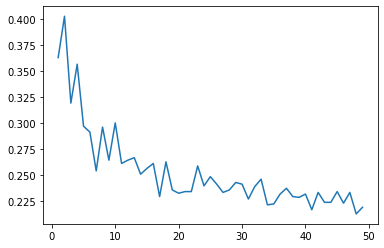

In [76]:
plt.plot(numrange, errmean)

In [77]:
# we will pick 30
bestnum = 30

In [78]:
m = 50
cret = ['gini', 'entropy']
err = np.zeros((2))

for i in range(r):
    for j in range(2):
        model = RandomForestClassifier(criterion=cret[j], n_estimators=bestnum)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)  
        error = 1 - accuracy_score(y_test, y_pred)
        err[j] = err[j] + error

In [79]:
err

array([7.14285714, 7.04761905])

In [80]:
bestcret = 'gini'
#we will pick gini since it has lowest sum od error

In [81]:
m = 50
r = 50
numrange = np.arange(1,m)
err = np.zeros((r,m-1))
besterror = 1

for i in range(r):
    for num in numrange:
        model = RandomForestClassifier(max_depth=num, criterion=bestcret, n_estimators=bestnum)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        error = 1 - accuracy_score(y_test, y_pred)
        err[i, num-1] = error
        if error < besterror:
            besterror = error

In [82]:
err.mean(axis=0).shape

(49,)

In [84]:
errmean = err.mean(axis=0)

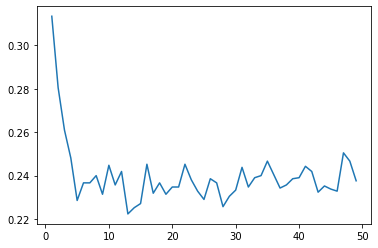

In [85]:
plt.plot(numrange, errmean)

In [86]:
bestdepth = 24

In [87]:
m = 20
r = 20
numrange = np.arange(2,m)
err = np.zeros((r,m-2))
besterror = 1

for i in range(r):
    for num in numrange:
        model = RandomForestClassifier(min_samples_split = num, max_depth=bestdepth, criterion=bestcret, n_estimators=bestnum)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        error = 1 - accuracy_score(y_test, y_pred)
        err[i, num-2] = error
        if error < besterror:
            besterror = error

In [88]:
errmean = err.mean(axis=0)

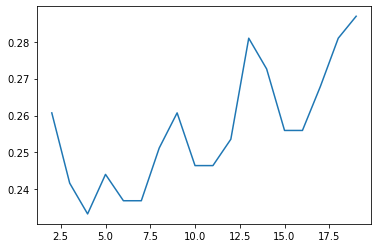

In [89]:
plt.plot(numrange, errmean)

In [90]:
minsp = 3

In [91]:
m = 20
r = 100
numrange = np.arange(2,m)
err = np.zeros((r,m-2))
besterror = 1

for i in range(r):
    for num in numrange:
        model = RandomForestClassifier(min_samples_leaf=num, min_samples_split = minsp, 
                                       max_depth=bestdepth, criterion=bestcret, n_estimators=bestnum)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        error = 1 - accuracy_score(y_test, y_pred)
        err[i, num-2] = error
        if error < besterror:
            besterror = error

In [92]:
errmean = err.mean(axis=0)

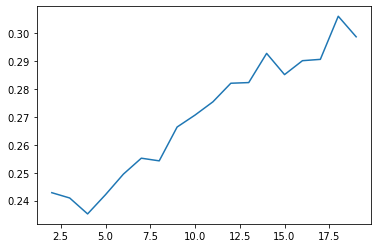

In [93]:
plt.plot(numrange, errmean)

In [94]:
msleaf=3

In [95]:
model = RandomForestClassifier(min_samples_leaf=msleaf, min_samples_split = minsp, 
                               max_depth=bestdepth, criterion=bestcret, n_estimators=bestnum)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy_score(y_val, y_pred)

0.8095238095238095

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

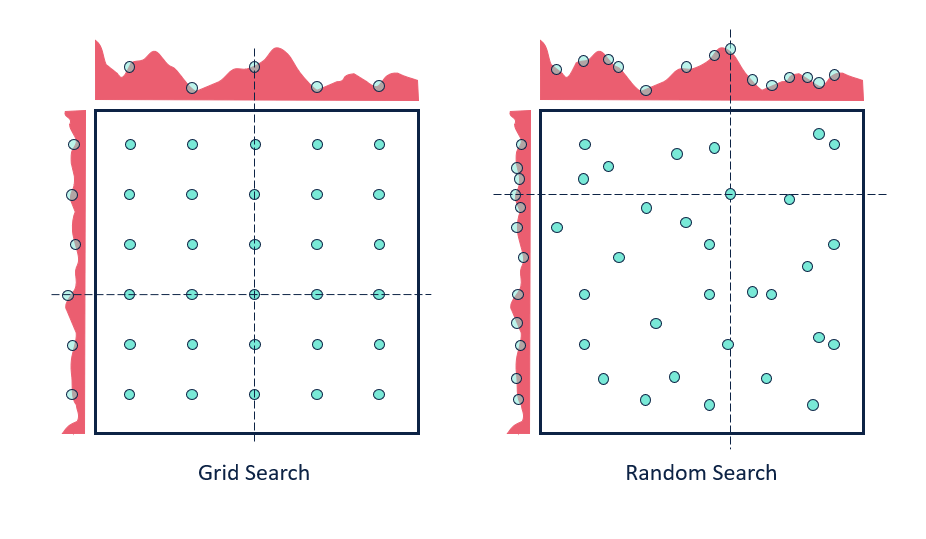

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [96]:
tuned_parameters = {'n_estimators': np.arange(2, 50, 2), 
                     'criterion': ['gini', 'entropy'],
                     'max_depth': np.arange(2, 50, 2)}

clf = GridSearchCV(
        RandomForestClassifier(n_jobs = -1),
            scoring='accuracy', param_grid = tuned_parameters).fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 28}
0.8713333333333333


In [97]:
model = RandomForestClassifier(**clf.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy_score(y_val, y_pred)

0.8095238095238095

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

distributions = {'n_estimators': randint(1, 60), 
                     'criterion': ['gini', 'entropy'],
                     'max_depth': randint(1, 50)}

clf = RandomizedSearchCV(RandomForestClassifier(n_jobs = -1), distributions, random_state=1488, n_iter=100)
search = clf.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

{'criterion': 'entropy', 'max_depth': 49, 'n_estimators': 24}
0.8640000000000001


In [19]:
model = RandomForestClassifier(**search.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy_score(y_val, y_pred)

0.7857142857142857

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

From my point of view: the dataset was to small to honestly compare such approaches (40 samples in ValSet).
But. I pretty much understand the key ideas behind all of these approaches and can conclude: 

There are few models that are not as much sensitive to sequential choice of parameters.
But generally, if you have enough computational resources - i suggest to use at least grid search instead of greedy search.
Random search is even better with enough of number of iterations since it does not tied to the grid - so it has all chances to succeed in optimum foundation.

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [107]:
import os
PATH = "./data/"
data = pd.read_csv(os.path.join(PATH, 'titanic', 'titanic_completed_eda.csv')).set_index('PassengerId')

In [108]:
train_data = data[:891] ## train part of dataset
train_data.head()

,Survived,Pclass,Sex,Family_Survival,Baby,Lost child,IsWomanOrBaby,FamilySize,FareBin_Code,AgeBin_Code
PassengerId,,,,,,,,,,
1,0.0,3,0,0.5,0,0.0,0,1,0,0
2,1.0,1,1,0.5,0,0.0,1,1,4,3
3,1.0,3,1,0.5,0,0.0,1,0,1,1
4,1.0,1,1,0.0,0,0.0,1,1,4,2
5,0.0,3,0,0.5,0,0.0,0,0,1,2


In [109]:
X = train_data.drop(columns = 'Survived')
y = train_data['Survived']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1488)

In [114]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier

distributions = {'min_impurity_decrease': uniform(), 
                 'criterion': ['gini', 'entropy'],
                 'max_depth': randint(1, 50),
                 'max_features': randint(1, 10)}

clf = RandomizedSearchCV(DecisionTreeClassifier(), distributions, random_state=1488, n_iter=500)
search = clf.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

{'criterion': 'entropy', 'max_depth': 19, 'max_features': 9, 'min_impurity_decrease': 0.033327539855975474}
0.8426451612903227


In [115]:
model = DecisionTreeClassifier(**search.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.8470149253731343

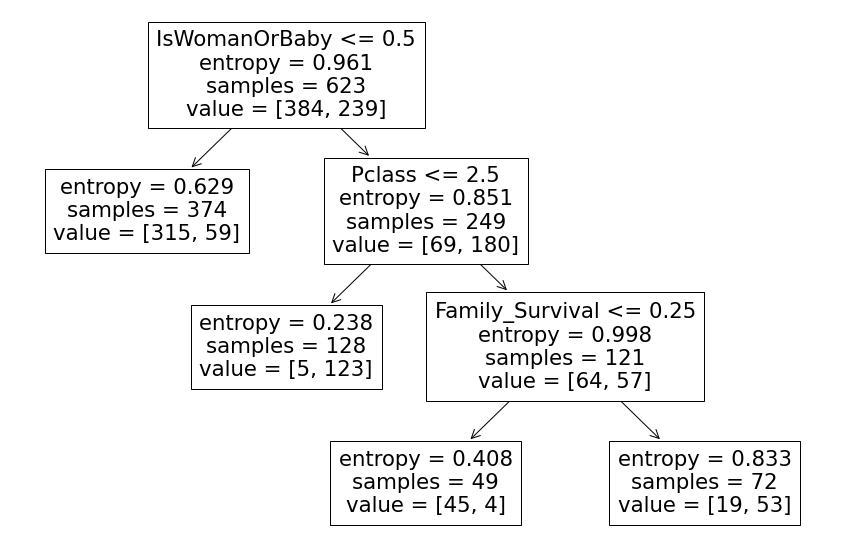

In [116]:
from sklearn import tree
plt.figure(figsize = (15,10))
tree.plot_tree(model, feature_names=train_data.drop(columns = 'Survived').columns)
print()

As we can see, there are only 5 leafs in our tree. And the features in nodes are: Pclass, IsWomanOrBaby, Family_Survival.
If you watched the stream dedicated to the titanic task analysis, i used to say that only these 3 features can improve your score a lot. Here's the result - our DecisionTreeClassifier chose the same features. 

If you are woman or baby and came from 1 class, you have much more chances to survive.
If you are not woman or baby and came from 3 class, you are almost for sure dead.
And if you are not woman or baby and did not come from 1 class, than your family survival is tested: whether one of your relatives died. If so - than you are also dead.

# Homework part 2. RandomForestRegressor

**Task 7 (2 points)**. Write your own *DecisionTreeRegressor* class with _MSE_ split criterion and settable parameter *max_depth*. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). <br>

Provide examples for different _max_depth_ parameter.

Of course you may re-use code for *DecisionTreeClassifier*. You need to figure out what needs to be changed in it for Classification -> Regression transformation.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [46]:
def mse_split(splits):
    """ Calculate sum of mse for the splits
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: sum of mse for the splits
    """    
    mse_sum = np.sum([np.sum((s-s.mean())**2) for s in splits])
    return -mse_sum

In [47]:
class RegTree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome = None
        self.criterion = mse_split
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None, max_depth=None, n_samples = 10):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = RegTree()
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = RegTree()
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome = np.sum(y) / y.shape[0]


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

In [48]:
import numpy as np

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 5))
y = f(X)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

In [121]:
model1 = RegTree()
model1.fit(X_train, y_train, max_depth=3)
y_pred1 = model1.predict(X_test)

In [122]:
model2 = DecisionTreeRegressor(random_state=0, max_depth=3)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

In [123]:
print(f"mean_squared_error for our custom RegTree is : \n{mean_squared_error(y_test, y_pred1)}")
print(f"mean_squared_error for sklearn-RegTree is: \n{mean_squared_error(y_test, y_pred2)}")

mean_squared_error for our custom RegTree is : 
0.019397623232302225
mean_squared_error for sklearn-RegTree is: 
0.019397623232302225


In [24]:
for depth in [3,5,10,20,50]:
    model = RegTree()
    model.fit(X_train, y_train, max_depth=depth)
    y_pred = model.predict(X_test)
    print(f"\nMSE with depth={depth}: {mean_squared_error(y_test, y_pred)}")


MSE with depth=3: 0.02562949910546019

MSE with depth=5: 0.013373306634429307

MSE with depth=10: 0.016284947481260022

MSE with depth=20: 0.011430017108267772

MSE with depth=50: 0.012806015158516475


In [25]:
for depth in [3,5,10,20,50]:
    model = DecisionTreeRegressor(max_depth = depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nMSE with depth={depth}: {mean_squared_error(y_test, y_pred)}")


MSE with depth=3: 0.02562949910546018

MSE with depth=5: 0.013177490330722994

MSE with depth=10: 0.012395392748175697

MSE with depth=20: 0.011697770908491004

MSE with depth=50: 0.012775873630390277


**Task 8 (2 points)**. Write your own _RandomForestRegressor_ class with MSE split criterion and settable parameter _max_depth_.  Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).<br>

Provide examples for different max_depth parameter.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [50]:
class RandomForestReg(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        self.trees = [RegTree() for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = row_pred
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [51]:
for depth in [3,5,10,20,50]:
    model = RandomForestReg(max_depth = depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nMSE with depth={depth}: {mean_squared_error(y_test, y_pred)}")


MSE with depth=3: 0.020654887972371364

MSE with depth=5: 0.01672436919025461

MSE with depth=10: 0.015259945902405583

MSE with depth=20: 0.013713906961429578

MSE with depth=50: 0.010702954486497268


In [187]:
for depth in [3,5,10,20,50]:
    model = RandomForestRegressor(max_depth = depth, n_estimators=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nMSE with depth={depth}: {mean_squared_error(y_test, y_pred)}")


MSE with depth=3: 0.020098012122573974

MSE with depth=5: 0.017775713897612202

MSE with depth=10: 0.016805547643717122

MSE with depth=20: 0.012330313405793148

MSE with depth=50: 0.012660059020029436


# Homework part 3 (bonus). Speeding up forest training process

Task 9 (3 points) Devise a way to speed up training against the default version of our custom RandomForestClassifier or your own RandomForestRegressor. You may want use joblib for parallelizing trees training. Provide graphs of time dependences on the number of trees in your fast version with different number of cores / threads used against default one.

In [118]:
class RandomForestRegJobs(RandomForestReg):
            
    def bootstrap_data(self, size):
        np.random.seed(1488)
        random.seed(1488)
        np.random.RandomState(1488)
        return np.random.randint(size, size=size)
    
    def single_fit(self, tree):
        if self.bootstrap:
            idxs = self.bootstrap_data(self.size)
            X = self.X[idxs]
            y = self.y[idxs]
        else:
            X = self.X
            y = self.y
                
        tree.fit(
            X,
            y,
            n_features=self.n_features,
            max_depth=self.max_depth,
        )
        
        return tree
    
    def fit(self, X, y, n_jobs):        
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        self.trees = Parallel(
            n_jobs=n_jobs, verbose=False)(
            map(delayed(self.single_fit), self.trees))

In [119]:
import time

In [120]:
tilmelist = []
joblist = []

for jobs in [1,2,4,8]:
    tl = [[],[]]
    joblist.append(jobs)
    for n in range(1,18,1):
        model = RandomForestRegJobs(n_estimators=n)
        
        start_time = time.time()
        for _ in range(10):
            model = RandomForestRegJobs(n_estimators=n)
            model.fit(X_train, y_train, n_jobs = jobs)
        dt = (time.time() - start_time)/10
        
        tl[1].append(dt)
        tl[0].append(n)
    tilmelist.append(tl)

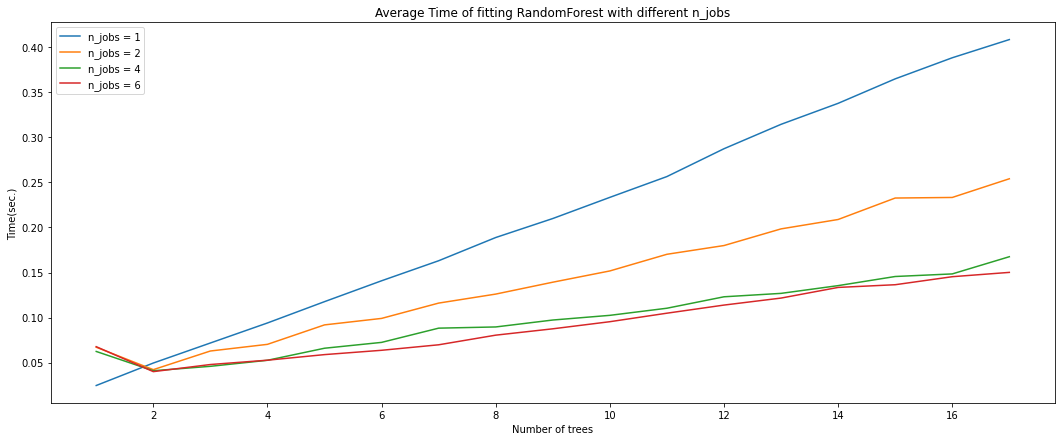

In [116]:
plt.figure(figsize=(18,7))
plt.xlabel('Number of trees')
plt.ylabel('Time(sec.)')
plt.title('Average Time of fitting RandomForest with different n_jobs') 

c = 0
for tl in tilmelist:
    sns.lineplot(x=tl[0], y=tl[1], label=f'n_jobs = {joblist[c]}')
    c+=1

As we can see on our plot, joblib is pretty useful instrument to optimize our fitting process. 
When n_jobs is set to 4\6, the process is 3-4 times faster than with single core usage.